In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from pandas_datareader import data as pdr
from pandas_datareader.data import DataReader
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
%matplotlib inline
import numpy as np
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [2]:
df = pd.read_csv(r'..\stocks\ORCL.csv', index_col=['Date'], parse_dates=['Date'])
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,36.009998,35.360001,36.009998,35.750000,18784400.0,32.958900
2016-01-05,36.119999,35.490002,35.860001,35.639999,25340700.0,32.857491
2016-01-06,36.139999,35.360001,35.500000,35.820000,18165700.0,33.023438
2016-01-07,35.680000,34.880001,35.250000,35.040001,22591400.0,32.304333
2016-01-08,35.279999,34.610001,35.130001,34.650002,21962200.0,31.944780


### Data Frame ‘Company_name’, ‘Date’, ‘High’, ‘Low’, ‘Open’ ,‘Close’, ‘Volume’, ‘Adj. Close’. 
* Volume is the number of shares that changed hands (Traded) during a given day. 
* Adj closing price (used to examine historical returns) factors in anything that might affect the stock price after the market is closed.

In [3]:
df.shape

(1287, 6)

In [4]:
# Described Oracle’s stock data
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1287.000000,1287.000000,1287.000000,1287.000000,1.287000e+03,1287.000000
mean,49.317304,48.483761,48.870909,48.892968,1.424076e+07,46.992690
std,6.797491,6.664525,6.735904,6.708369,7.782766e+06,7.457435
min,34.230000,33.130001,33.799999,33.939999,3.331700e+06,31.290215
25%,44.640001,43.875000,44.199999,44.285000,9.556250e+06,41.755733
50%,49.470001,48.759998,49.099998,49.189999,1.231610e+07,46.924309
75%,54.340000,53.514999,53.895000,53.959999,1.621425e+07,52.620239
max,66.199997,65.150002,65.410004,65.300003,7.517600e+07,65.051079


In [5]:
df.nunique()

High          971
Low           986
Open          959
Close         950
Volume       1282
Adj Close    1199
dtype: int64

In [6]:
#cleaning the data
#check the missing data
df.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

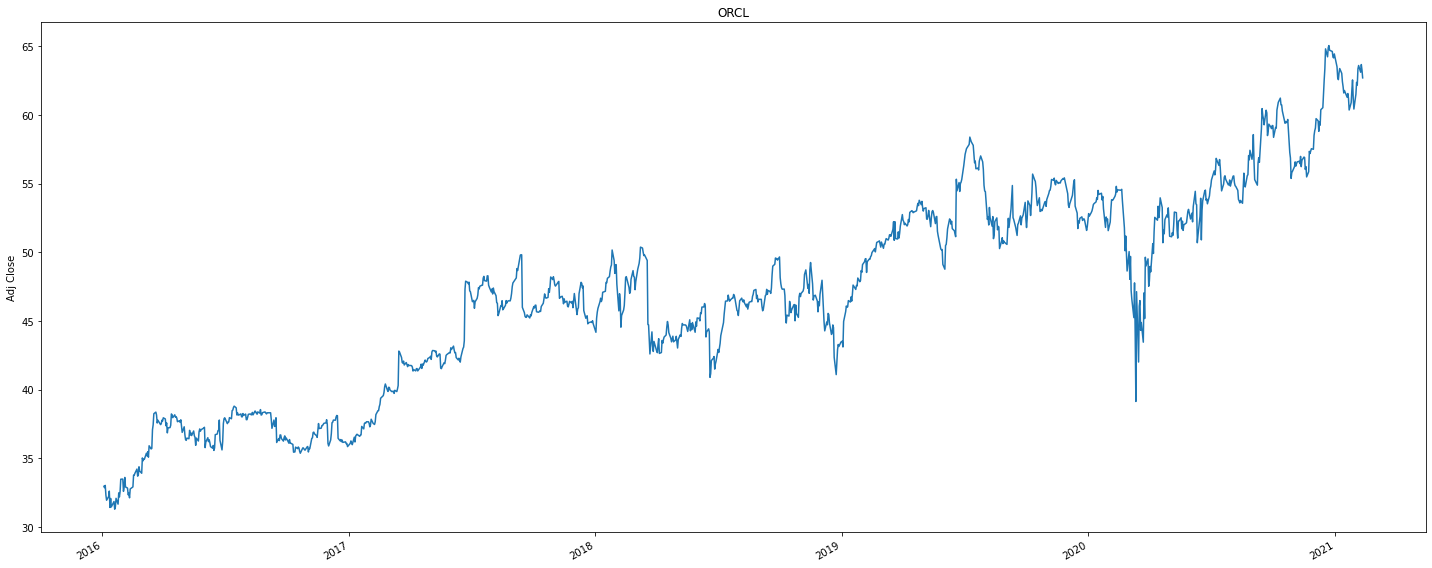

In [7]:
# To see a historical view of the closing price. For historical view I’ll be using Adj. Closing price
plt.figure(figsize=(20, 8))
df['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title('ORCL')
plt.tight_layout()

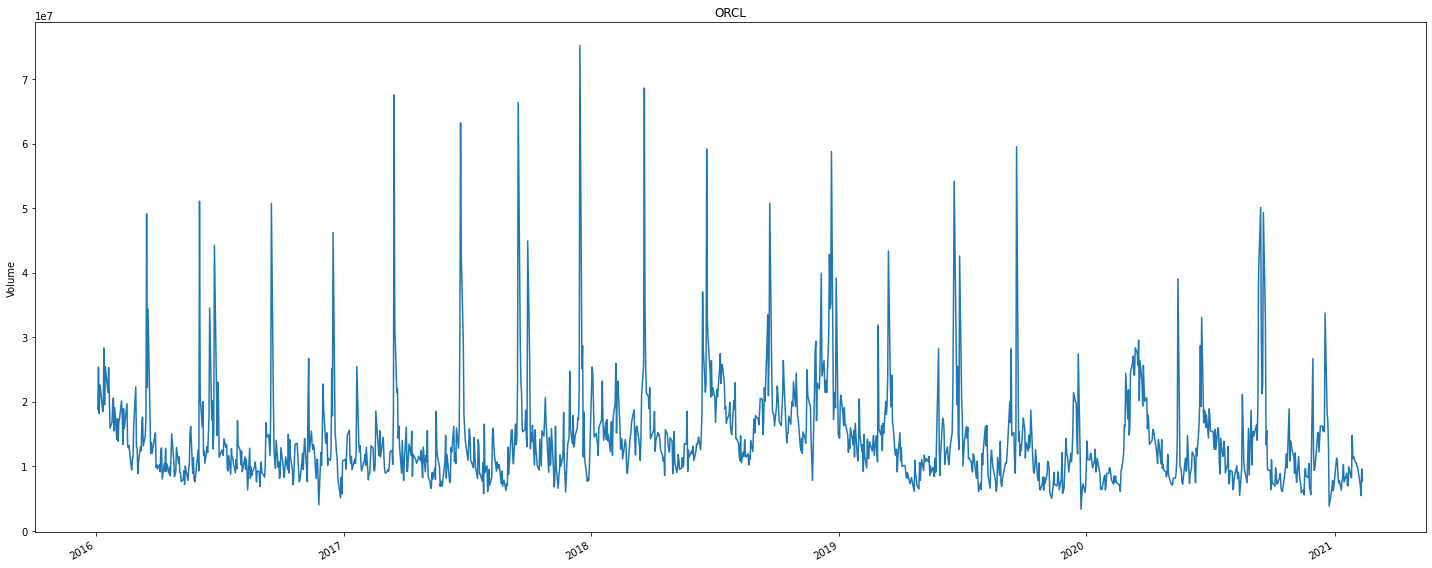

In [8]:
# For plotting the total volume of stock being traded each day
plt.figure(figsize=(20, 8))
df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title('ORCL')
plt.tight_layout()

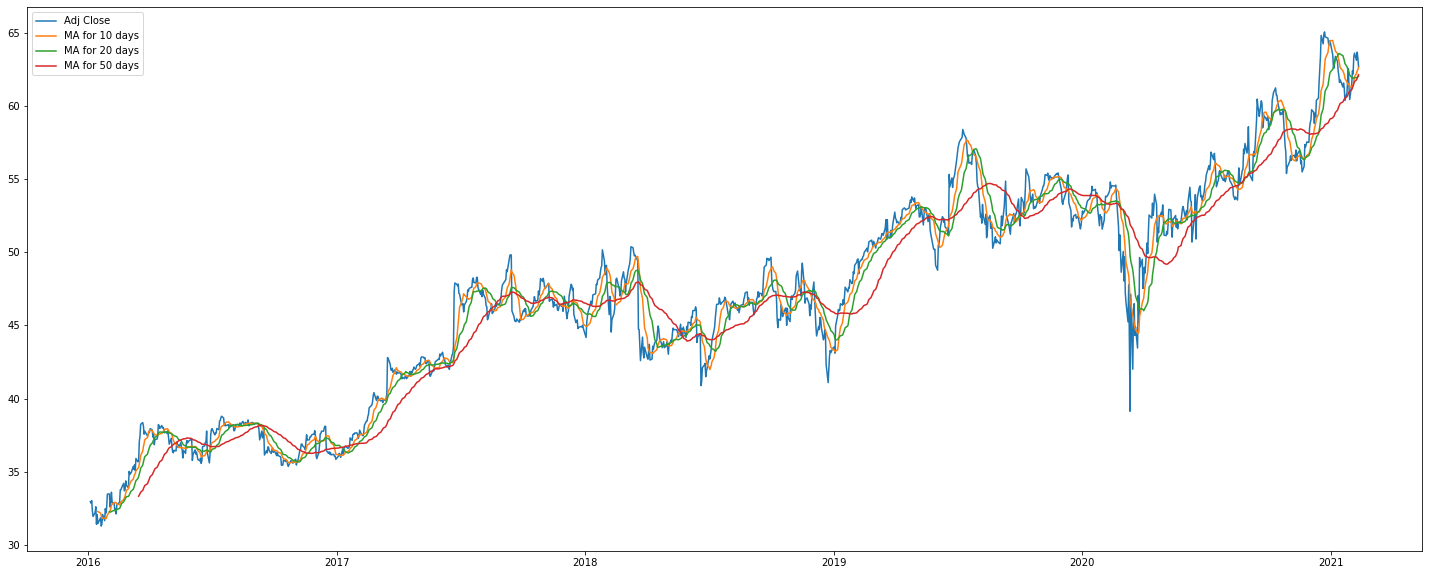

In [9]:
# Calculating Moving Average with lag of 10, 20, 50 days.
ma_day = [10, 20, 50]
for ma in ma_day:
    column_name = f'MA for {ma} days'
    df[column_name] = df['Adj Close'].rolling(ma).mean()

fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(df['Adj Close'], label= 'Adj Close')
ax.plot(df['MA for 10 days'], label='MA for 10 days')
ax.plot(df['MA for 20 days'], label='MA for 20 days')
ax.plot(df['MA for 50 days'], label='MA for 50 days')
ax.legend()
plt.show()

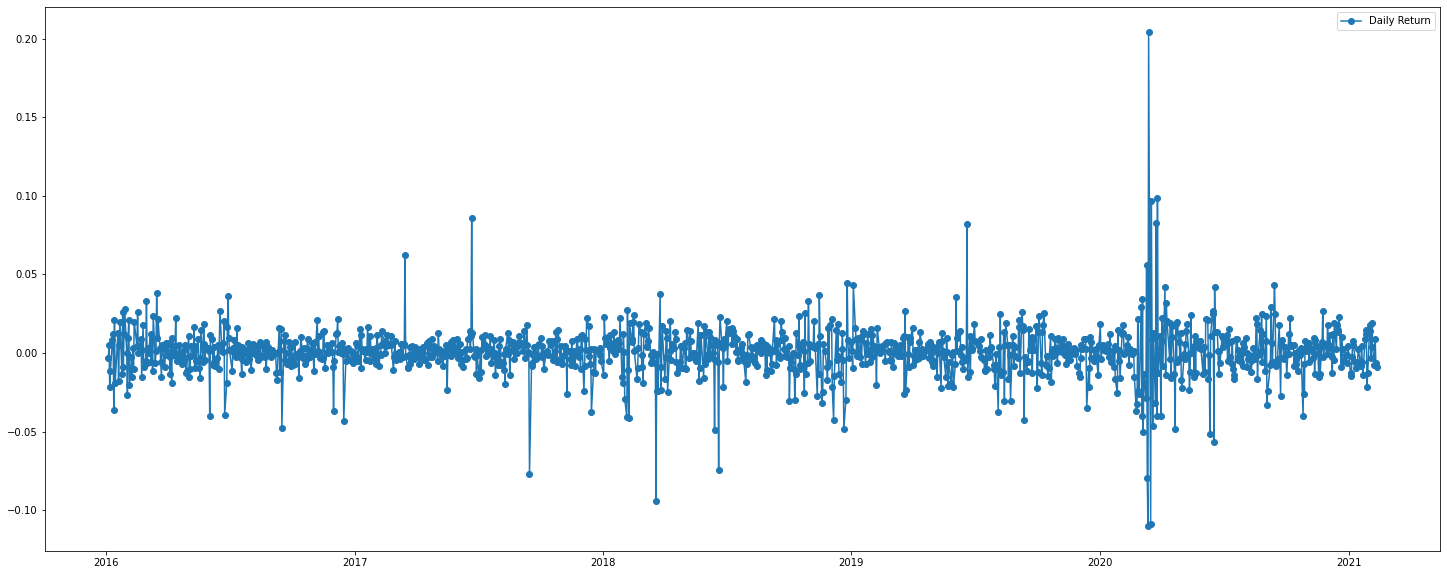

In [10]:
df['Daily Return'] = df['Adj Close'].pct_change()
    
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(df['Daily Return'], label= 'Daily Return', linestyle='-', marker='o')
ax.legend()
plt.show()

### Test for stationary series

In [11]:
df = pd.read_csv(r'..\stocks\ORCL.csv', index_col=['Date'], parse_dates=['Date'])
# Drop NaNs
df = df.dropna()
# Select the proper time period for daily aggreagation
df = df['2019-01-02':'2020-12-05'].resample('D').sum()
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,45.340000,44.450001,44.480000,45.220001,14320400.0,43.526508
2019-01-03,45.500000,44.410000,44.750000,44.779999,19868700.0,43.102985
2019-01-04,46.950001,45.250000,45.369999,46.709999,20984000.0,44.960709
2019-01-05,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2019-01-06,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


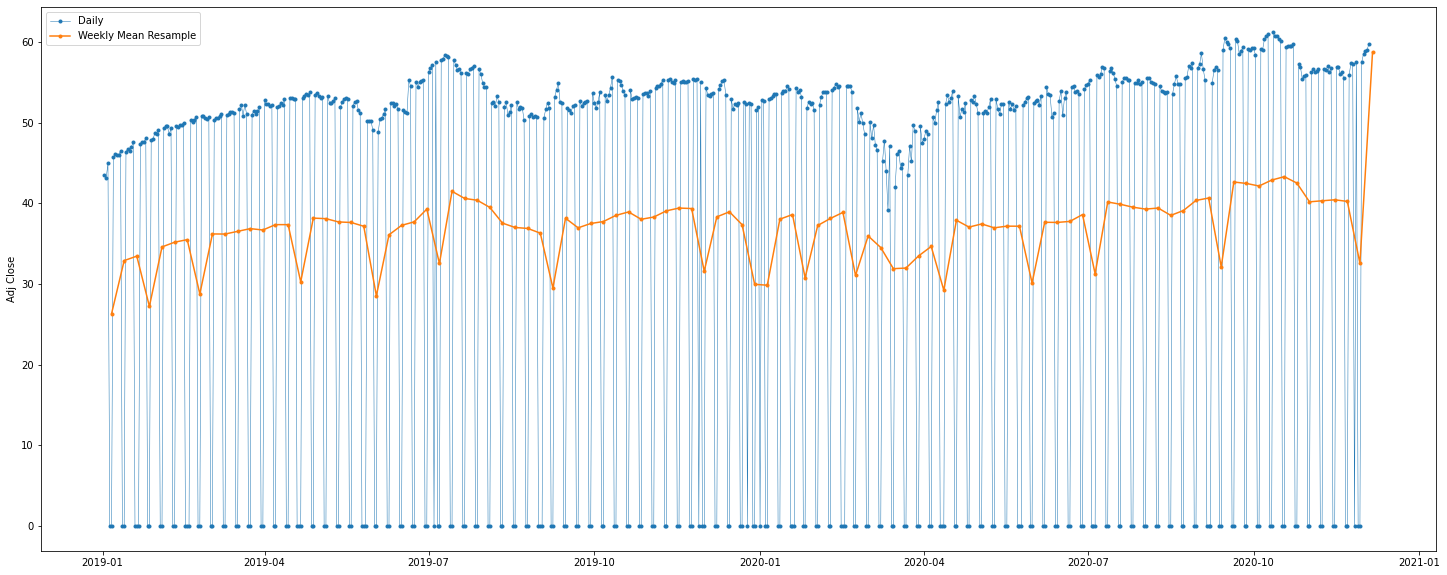

In [12]:
adj_close = df['Adj Close']
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(adj_close,marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(adj_close.resample('W').mean(),marker='o', markersize=3, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('Adj Close')
ax.legend();

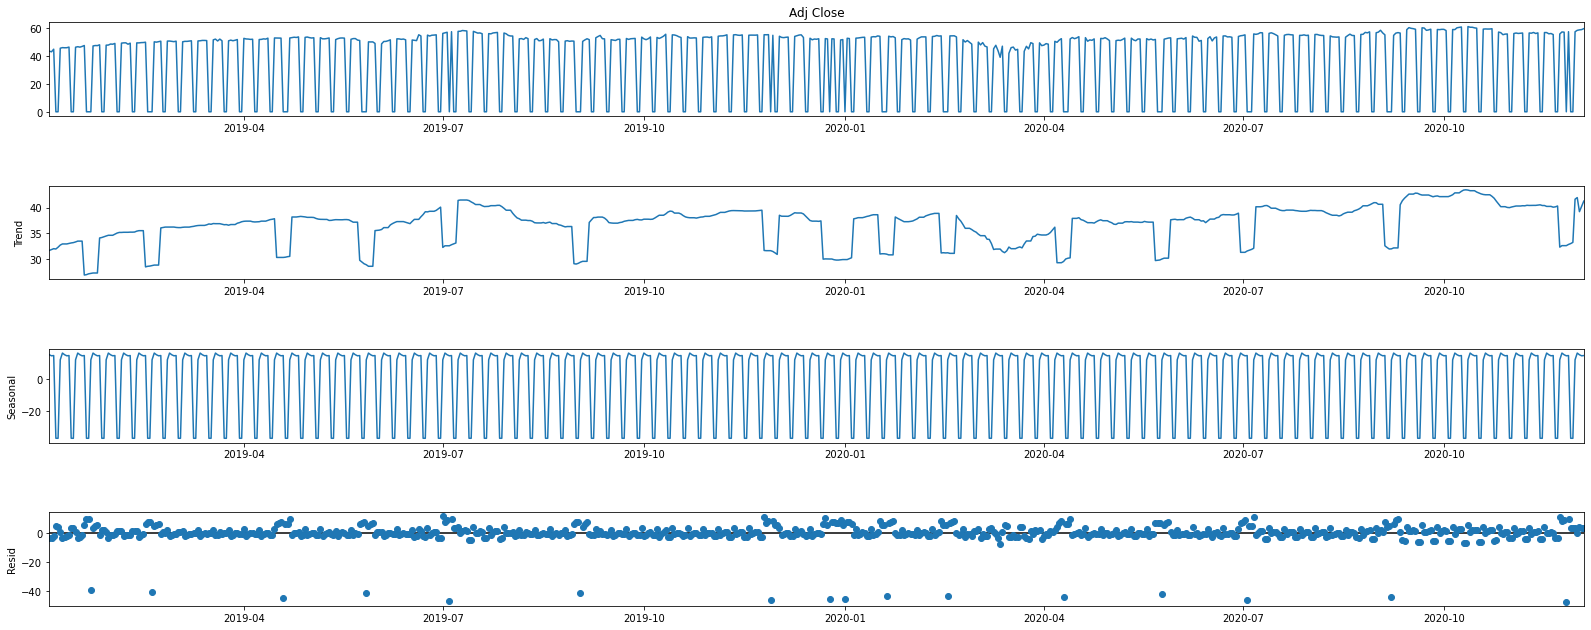

In [13]:
# graphs to show seasonal_decompose
def seasonal_decompose (adj_close):
    decomposition = sm.tsa.seasonal_decompose(adj_close, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(25, 10)
    plt.show()
    
seasonal_decompose(adj_close)

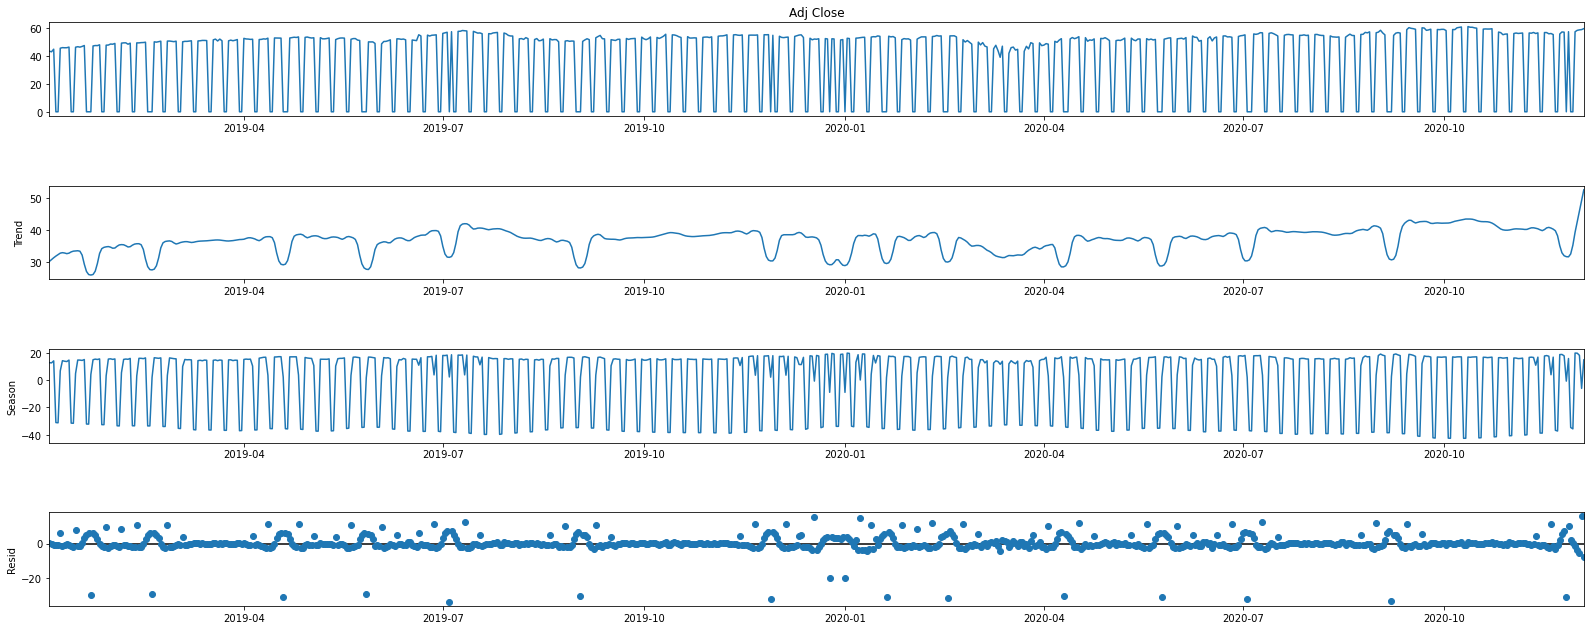

In [14]:
# graphs to show stl_decompose
def stl_decompose (adj_close):
    decomposition = STL(adj_close).fit()
    fig = decomposition.plot()
    fig.set_size_inches(25, 10)
    plt.show()

stl_decompose(adj_close)

### Check for Stationarity:

In [15]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

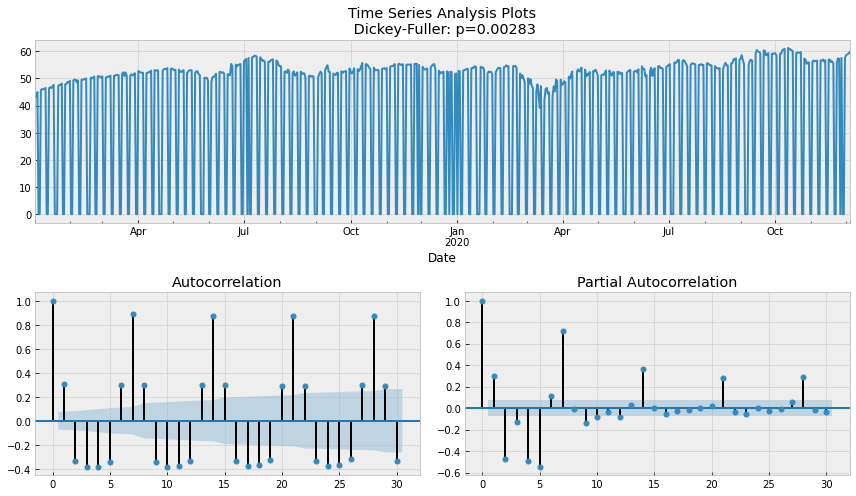

In [16]:
tsplot(df['Adj Close'], lags=30)

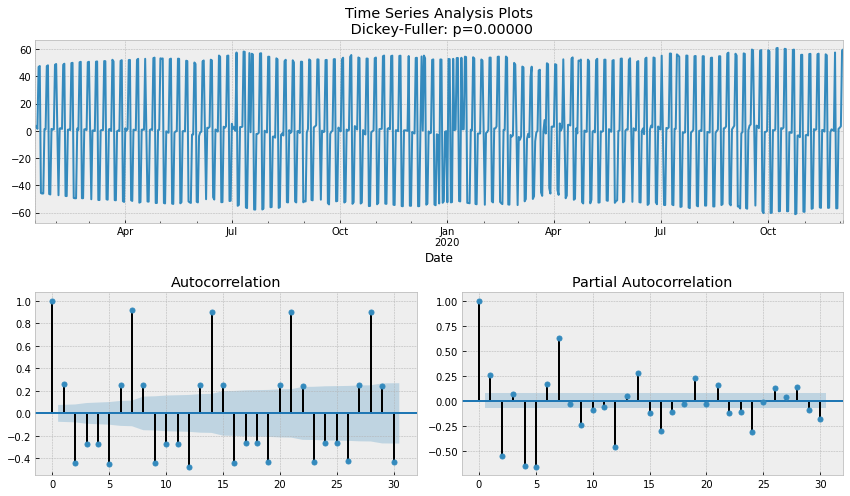

In [17]:
ads_diff = df['Adj Close'] - df['Adj Close'].shift(12)
tsplot(ads_diff[12:], lags=30)